# Power Flow Calculations With Main Field Losses

The test bench consists of three nodes, a three winding transformer and two loads at the medium and low voltage port of
the transformer. We sweep through tap positions and active power consumption of the loads, respectively.
This is meant to get an insight into the results of the transformer, that are achieved with DIgSILENT PowerFactory.

In order to obtain the desired results, you have to import the `PowerFactoryThreeWindingControl.py`-script within the
appropriate PowerFactory project (`inputData/TransformerThreeWindingTestBench.pfd`) and execute it.
Please follow the instructions given in the read me section.


## Definition of examination parameters
Define some important parameters for the later assessment.

In [1]:
import json
import os
from tcv.encoder import CustomDecoder
s_rated_hv_mva: float = 300
s_rated_mv_mva: float = 300
s_rated_lv_mva: float = 100
tap_min: int = -10
tap_max: int = 10
tap_range = range(tap_min, tap_max + 1)
v_ref_kv: float = 380
s_ref_mva: float = 300
p_step_size: float = 0.25  # in p.u.

## Load the results

In [2]:
result_directory = os.path.join("..", "..", "..", "results", "three_winding")
result_file = os.path.join(result_directory, "dpf_withMainFieldLosses.json")

if not os.path.exists(result_file):
    raise IOError("Cannot find the needed results' file '%s'." % str(result_file))

with open(result_file, "r") as file_to_read:
    json_string = file_to_read.read()
    results = json.loads(json_string, object_hook=CustomDecoder.custom_decode)

## Correct tapping in no-load situation
Check, if the transformer adjusts nodal voltages correctly, when not being loaded at all.

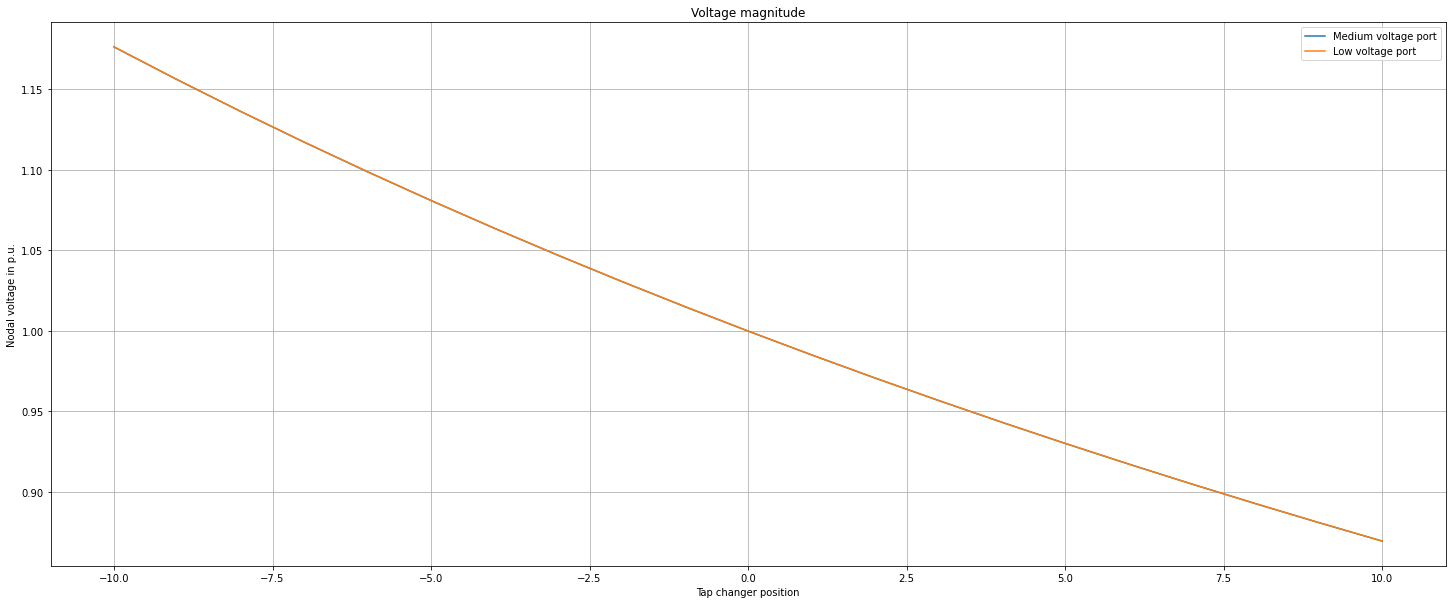

In [3]:
from matplotlib import pyplot as plt
import numpy as np

# Collect the needed results
v_mv_pu = []
v_lv_pu = []
for exam in filter(lambda entry: entry['p_mv'] == 0.0 and entry['p_lv'] == 0.0, results):
    # Unbox information from examination
    tap_pos = exam['tap_pos']
    v_mv_pu.append(exam['result'].v_mv_pu)
    v_lv_pu.append(exam['result'].v_lv_pu)

fig_no_load, ax_no_load = plt.subplots(figsize=(25, 10))
ax_no_load.set_title('Voltage magnitude')
ax_no_load.set_xlabel('Tap changer position')
ax_no_load.set_ylabel('Nodal voltage in p.u.')
ax_no_load.grid()
ax_no_load.plot(np.array(tap_range), np.array(v_mv_pu), label='Medium voltage port')
ax_no_load.plot(np.array(tap_range), np.array(v_lv_pu), label='Low voltage port')
ax_no_load.legend()

## Correct tapping in loaded situation

As the power rating of the high voltage port is 300 MVA, that of the medium voltage port 300 MVA as well and 100 MVA for
the low voltage port, the following applies:
The medium voltage load is varied within the range of +/- 300 MVA.
The low voltage load is only varied within the permissible range, that is left.
E.g. if the medium voltage load is 250 MVA, ist only is varied from -100 MVA to 50 MVA.

### Assess the results

#### Nodal voltages in neutral tap position

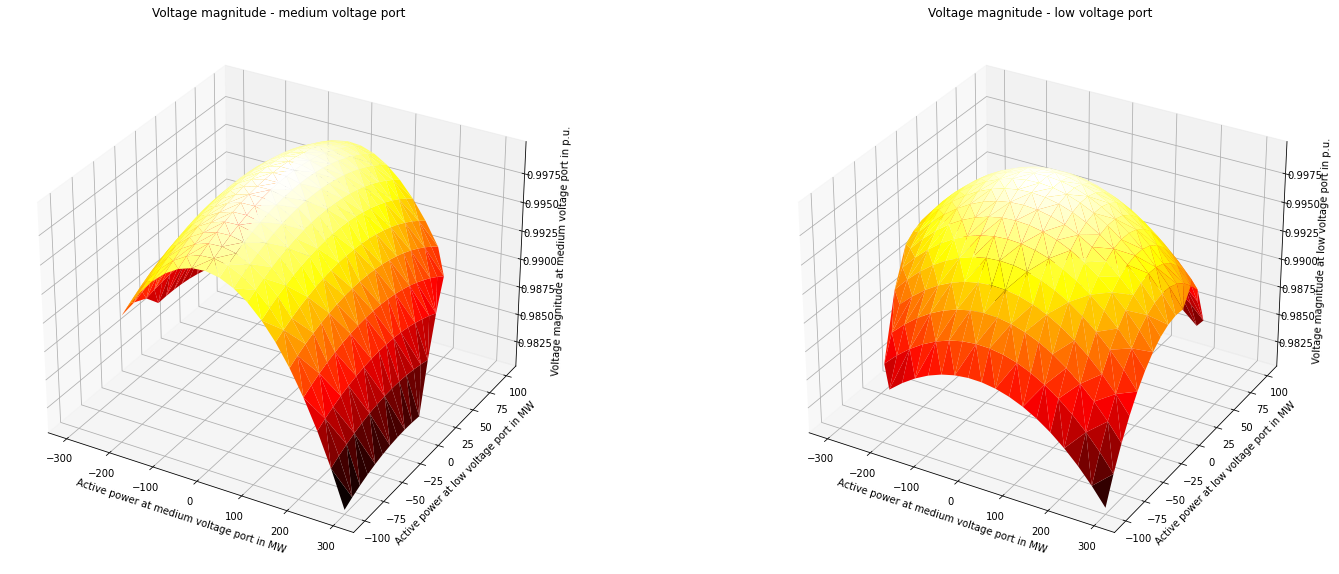

In [4]:
# --- Extract all information from results ---
p_mv_mw = []  # Power at medium voltage node
p_lv_mw = []  # Power at low voltage node
p_hv_mw = {str(tap_pos): [] for tap_pos in tap_range}  # Active power at high voltage node
q_hv_mvar = {str(tap_pos): [] for tap_pos in tap_range}  # Reactive power at high voltage node
v_mv_pu = {str(tap_pos): [] for tap_pos in tap_range}  # Voltage magnitude at medium voltage node
v_lv_pu = {str(tap_pos): [] for tap_pos in tap_range}  # Voltage magnitude at low voltage node
for result in results:
    tap_pos = result['tap_pos']
    idx = str(tap_pos)

    # Only register the input values in one tap position
    if tap_pos == 0:
        p_mv_mw.append(result['p_mv'])
        p_lv_mw.append(result['p_lv'])

    # Register nodal voltages and resulting joint power for all tap positions
    v_mv_pu[idx].append(result['result'].v_mv_pu)
    v_lv_pu[idx].append(result['result'].v_lv_pu)
    p_hv_mw[idx].append(result['result'].p_hv_kw / 1000)
    q_hv_mvar[idx].append(result['result'].q_hv_kvar / 1000)

v_min = {key: min(voltages) for key, voltages in v_mv_pu.items()}
v_max = {key: max(voltages) for key, voltages in v_mv_pu.items()}

fig_neutral_tap_v = plt.figure(figsize=(25, 10))
cmap_neutral_tap = plt.get_cmap('hot')
ax_neutral_tap_v_mv = fig_neutral_tap_v.add_subplot(1, 2, 1, projection='3d')
ax_neutral_tap_v_mv.set_title('Voltage magnitude - medium voltage port')
ax_neutral_tap_v_mv.set_xlabel('Active power at medium voltage port in MW')
ax_neutral_tap_v_mv.set_ylabel('Active power at low voltage port in MW')
ax_neutral_tap_v_mv.set_zlabel('Voltage magnitude at medium voltage port in p.u.')
ax_neutral_tap_v_mv.set_zlim(v_min['0'], v_max['0'])
ax_neutral_tap_v_mv.plot_trisurf(np.array(p_mv_mw), np.array(p_lv_mw), np.array(v_mv_pu['0']), cmap=cmap_neutral_tap)

ax_neutral_tap_v_lv = fig_neutral_tap_v.add_subplot(1, 2, 2, projection='3d')
ax_neutral_tap_v_lv.set_title('Voltage magnitude - low voltage port')
ax_neutral_tap_v_lv.set_xlabel('Active power at medium voltage port in MW')
ax_neutral_tap_v_lv.set_ylabel('Active power at low voltage port in MW')
ax_neutral_tap_v_lv.set_zlabel('Voltage magnitude at low voltage port in p.u.')
ax_neutral_tap_v_lv.set_zlim(v_min['0'], v_max['0'])
ax_neutral_tap_v_lv.plot_trisurf(np.array(p_mv_mw), np.array(p_lv_mw), np.array(v_lv_pu['0']), cmap=cmap_neutral_tap)

##### Conclusions
-   The higher the power consumption, the lower the nodal voltages.
-   Power consumption at one port also slightly affects the nodal voltage magnitude at the other port.
-   When only varying the power consumption at the low voltage port:
    Voltage magnitude at low voltage port varies more than on medium voltage port.
    Therefore, Main part of the impedance has to be between star point and low voltage port.
-   Same applies for the impedance between star point and medium voltage port.
-   Nodal voltage is 1.0 p.u. at both ports for the no-load situation.
    This meets expectations for a transformer without main field losses.

##### Open questions
-   Why isn't the nodal voltage magnitude higher, when feeding in power? Let's have a look at the high voltage port power

#### High voltage port power in neutral tap position

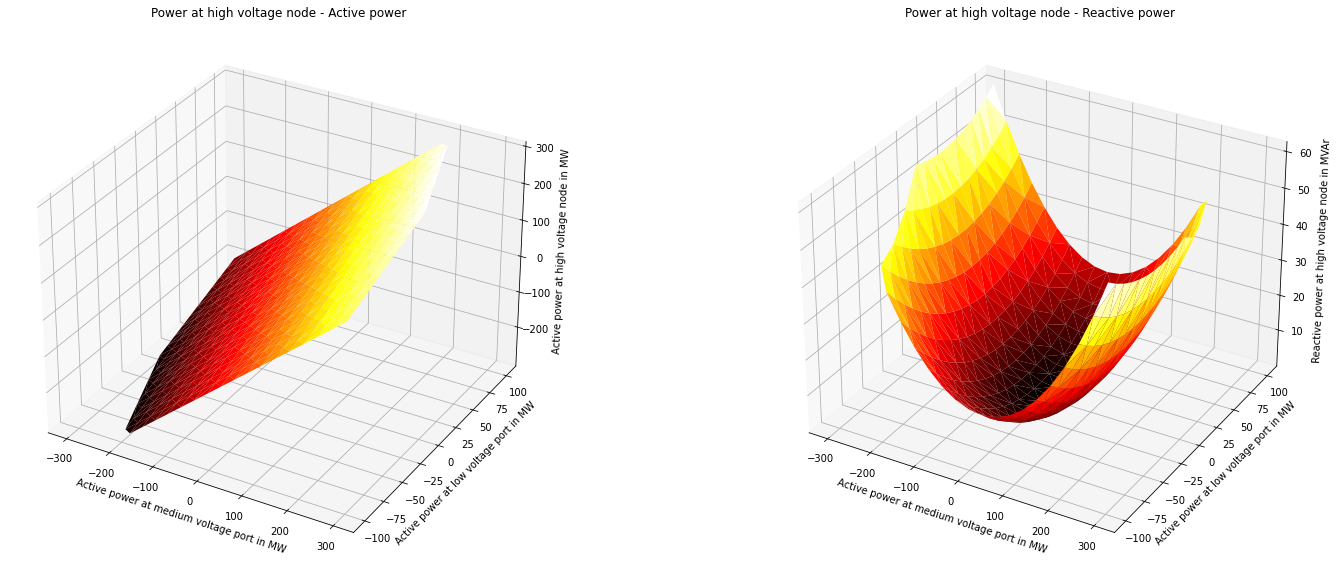

In [5]:
fig_neutral_tap_s_hv = plt.figure(figsize=(25, 10))
ax_neutral_tap_p_hv = fig_neutral_tap_s_hv.add_subplot(1, 2, 1, projection='3d')
ax_neutral_tap_p_hv.set_title('Power at high voltage node - Active power')
ax_neutral_tap_p_hv.set_xlabel('Active power at medium voltage port in MW')
ax_neutral_tap_p_hv.set_ylabel('Active power at low voltage port in MW')
ax_neutral_tap_p_hv.set_zlabel('Active power at high voltage node in MW')
ax_neutral_tap_p_hv.plot_trisurf(np.array(p_mv_mw), np.array(p_lv_mw), np.array(p_hv_mw['0']), cmap=cmap_neutral_tap)

ax_neutral_tap_q_hv = fig_neutral_tap_s_hv.add_subplot(1, 2, 2, projection='3d')
ax_neutral_tap_q_hv.set_title('Power at high voltage node - Reactive power')
ax_neutral_tap_q_hv.set_xlabel('Active power at medium voltage port in MW')
ax_neutral_tap_q_hv.set_ylabel('Active power at low voltage port in MW')
ax_neutral_tap_q_hv.set_zlabel('Reactive power at high voltage node in MVAr')
ax_neutral_tap_q_hv.plot_trisurf(np.array(p_mv_mw), np.array(p_lv_mw), np.array(q_hv_mvar['0']), cmap=cmap_neutral_tap)

##### Conclusions
-   Active power seems to sum up as expected, taking resistive losses into account
-   Reactive power is purely inductive and increases with total transferred power
-   After further investigation, it can be found, that the magnitude and R/X-ratio of the transformer's impedance can
    cause a lower voltage magnitude at transformer's medium and low voltage ports

#### Nodal voltages for different tap positions
Specifically, at tap position -10, -5, 0, 5, 10.

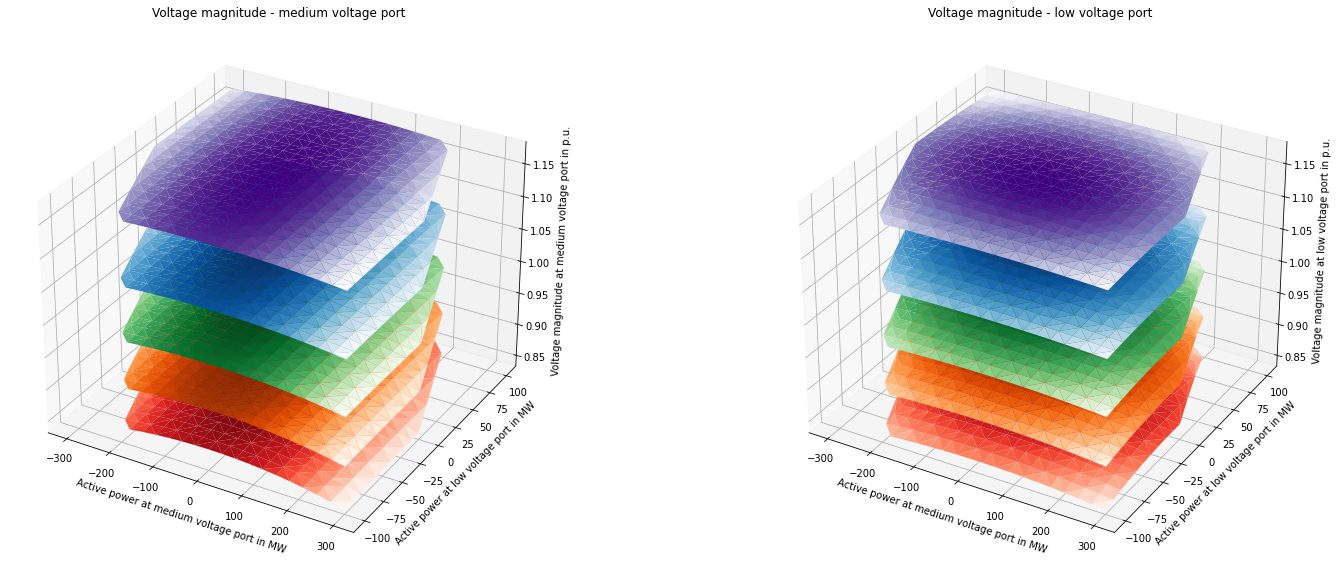

In [6]:
fig_tap_v = plt.figure(figsize=(25, 10))
ax_tap_v_mv = fig_tap_v.add_subplot(1, 2, 1, projection='3d')
ax_tap_v_mv.set_title('Voltage magnitude - medium voltage port')
ax_tap_v_mv.set_xlabel('Active power at medium voltage port in MW')
ax_tap_v_mv.set_ylabel('Active power at low voltage port in MW')
ax_tap_v_mv.set_zlabel('Voltage magnitude at medium voltage port in p.u.')
v_min_ax = min([v_min['-10'], v_min['-5'], v_min['0'], v_min['5'], v_min['10']])
v_max_ax = max([v_max['-10'], v_max['-5'], v_max['0'], v_max['5'], v_max['10']])
ax_tap_v_mv.set_zlim(v_min_ax, v_max_ax)
ax_tap_v_mv.plot_trisurf(np.array(p_mv_mw), np.array(p_lv_mw), np.array(v_mv_pu['-10']), cmap=plt.get_cmap('Purples'))
ax_tap_v_mv.plot_trisurf(np.array(p_mv_mw), np.array(p_lv_mw), np.array(v_mv_pu['-5']), cmap=plt.get_cmap('Blues'))
ax_tap_v_mv.plot_trisurf(np.array(p_mv_mw), np.array(p_lv_mw), np.array(v_mv_pu['0']), cmap=plt.get_cmap('Greens'))
ax_tap_v_mv.plot_trisurf(np.array(p_mv_mw), np.array(p_lv_mw), np.array(v_mv_pu['5']), cmap=plt.get_cmap('Oranges'))
ax_tap_v_mv.plot_trisurf(np.array(p_mv_mw), np.array(p_lv_mw), np.array(v_mv_pu['10']), cmap=plt.get_cmap('Reds'))

ax_tap_v_lv = fig_tap_v.add_subplot(1, 2, 2, projection='3d')
ax_tap_v_lv.set_title('Voltage magnitude - low voltage port')
ax_tap_v_lv.set_xlabel('Active power at medium voltage port in MW')
ax_tap_v_lv.set_ylabel('Active power at low voltage port in MW')
ax_tap_v_lv.set_zlabel('Voltage magnitude at low voltage port in p.u.')
ax_tap_v_lv.set_zlim(v_min_ax, v_max_ax)
ax_tap_v_lv.plot_trisurf(np.array(p_mv_mw), np.array(p_lv_mw), np.array(v_lv_pu['-10']), cmap=plt.get_cmap('Purples'))
ax_tap_v_lv.plot_trisurf(np.array(p_mv_mw), np.array(p_lv_mw), np.array(v_lv_pu['-5']), cmap=plt.get_cmap('Blues'))
ax_tap_v_lv.plot_trisurf(np.array(p_mv_mw), np.array(p_lv_mw), np.array(v_lv_pu['0']), cmap=plt.get_cmap('Greens'))
ax_tap_v_lv.plot_trisurf(np.array(p_mv_mw), np.array(p_lv_mw), np.array(v_lv_pu['5']), cmap=plt.get_cmap('Oranges'))
ax_tap_v_lv.plot_trisurf(np.array(p_mv_mw), np.array(p_lv_mw), np.array(v_lv_pu['10']), cmap=plt.get_cmap('Reds'))

plt.show()

##### Conclusions
-   Overall nodal voltages rise with lowering tap changer position
-   The lower the tap changer position, the higher the impact of one step-change
-   Voltage surfaces maintain a similar shape
    -   Curvature is higher for lower voltages
    -   This is, because the same power is served with a higher current and therefore, the voltage drop across the
        transformer is higher